In [ ]:
!pip install deluca

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 742.3 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 4.1 MB/s eta 0:00:00
  Created wheel for deluca: filename=deluca-0.0.18-py3-none-any.whl size=12713 sha256=5137aa22a10cac50b32257e60bbca9a5616cb6cf292139fc339fa75c925679de
  Stored in directory: /root/.cache/pip/wheels/0e/33/f5/b76484529d6c9c910a69bcd76cc34b9aa1060034ab41d11154
Successfully built deluca


In [ ]:
import jax
import jax.numpy as jnp
import tqdm
import flax
import deluca
import matplotlib.pyplot as plt
from deluca.envs import PlanarQuadrotor

ModuleNotFoundError: No module named 'deluca.envs'

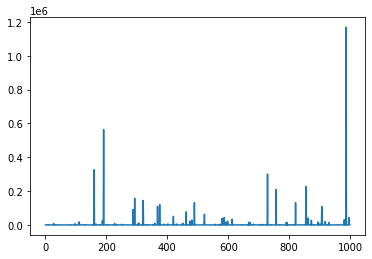

In [ ]:


plt.plot(ppl[:,0].T)
plt.show()

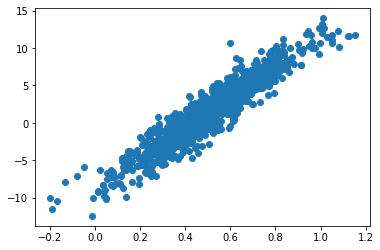

In [ ]:
log_wealth = np.log(ppl[:,0].T)
plt.scatter(ppl[:,1].T, log_wealth)
plt.show()